# Step 1 : importing Essential Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
base_skin_dir = os.path.join('..', 'input')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'}

In [3]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))# Creating New Columns for better readability
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']


In [4]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)
# Reshape image in 3 dimensions (height = 128px, width = 128px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(32, 32, 3))
x_test = x_test.reshape(x_test.shape[0], *(32, 32, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(32, 32, 3))
input_shape = (32, 32, 3)
num_classes = 7

In [53]:
def evaluate_model(n_nodes, x_train, y_train, x_test, y_test):
        # configure the model based on the data
        # define model
        model = Sequential()
        model.add(Conv2D(32, input_shape=input_shape, activation='relu', kernel_size=(3, 3) ,padding = 'Same'))
        model.add(MaxPool2D(pool_size = (2, 2)))
        
        
        model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
        model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.40))

        model.add(Flatten())
        model.add(Dense(num_classes, activation='softmax'))
        # compile model
        opt = optik
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        # fit model on train set
        history = model.fit(x_train, y_train, epochs=100, verbose=0)
        # evaluate model on test set
        _, test_acc = model.evaluate(x_test, y_test, verbose=0)
        return history, test_acc

<function matplotlib.pyplot.show(*args, **kw)>

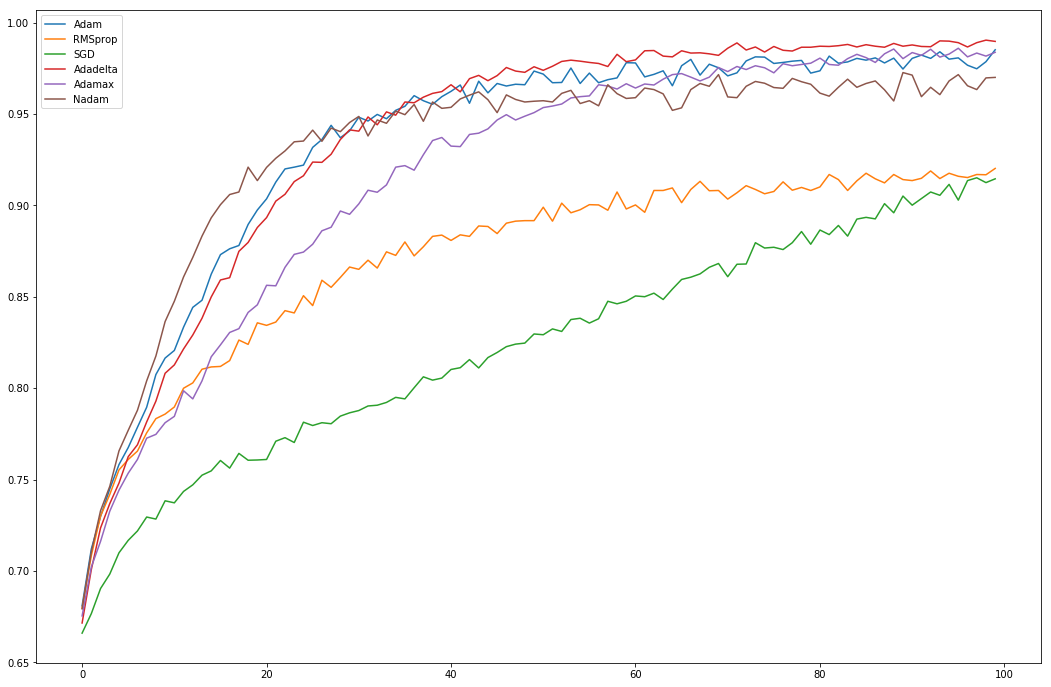

In [54]:
plt.rcParams["figure.figsize"] = (18,12)
opt_list = ["Adam","RMSprop","SGD","Adadelta","Adamax","Nadam"]
for optik in opt_list:
    history, result = evaluate_model(optik, x_train, y_train, x_test, y_test)
    plt.plot(history.history['acc'], label=str(optik))
plt.legend()
plt.show